In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import random as rd
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sns.set_theme(context="notebook")
import matplotlib.image as mpimg

from scipy.fft import fft
from scipy.stats.distributions import chi2

 
from numpy import angle, unwrap, sin, cos, sum, reshape



In [17]:
def vc_pratico(ord,alpha=0.05):
  return np.quantile(ord,1-alpha)

def ord_CebullaRm(sinal, tamanhoJanela, M):
    sinal = reshape(sinal[0:tamanhoJanela*M], (M,tamanhoJanela))

    FFT_SINAL = fft(sinal).transpose()
    angulo = unwrap(angle(FFT_SINAL))
    r = abs(FFT_SINAL)

    s = np.empty(tamanhoJanela)
    c = np.empty(tamanhoJanela)
    for i in range(tamanhoJanela):          # i => rank number of the spectral component i
      s[i] =  i*(sum(r[i]*np.sin(angulo[i]))) 
      c[i] = i*(sum(r[i]*np.cos(angulo[i])))

    s = s/M
    c = c/M
    Rm =  np.sqrt(c**2+s**2)/(M*np.sqrt(M))       # modified rayleigh test

    return [FFT_SINAL,Rm] 
    

def ordCSM(sinal, tamanhoJanela, M):
      sinal = reshape(sinal[0:tamanhoJanela*M], (tamanhoJanela,M))

      FFT_SINAL = fft(sinal)
      angulo = unwrap(angle(FFT_SINAL))

      s = ((1/M)*(sum(sin(angulo),1)))**2
      c = ((1/M)*(sum(cos(angulo),1)))**2
      CSM =  c+s
      
      return [FFT_SINAL,CSM]
    

def vcCSM(M, alpha = 0.05, VERBOSE=0):
    vc = chi2.ppf(1-alpha,2)/(2*M)
    
    if VERBOSE==1:
        print('Significância desejada: ',alpha*100,'\b%')
    if VERBOSE==2:
        print('Significância desejada: ',alpha*100,'\b%')
        print('Valor crítico CSM: ',vc)

    return vc

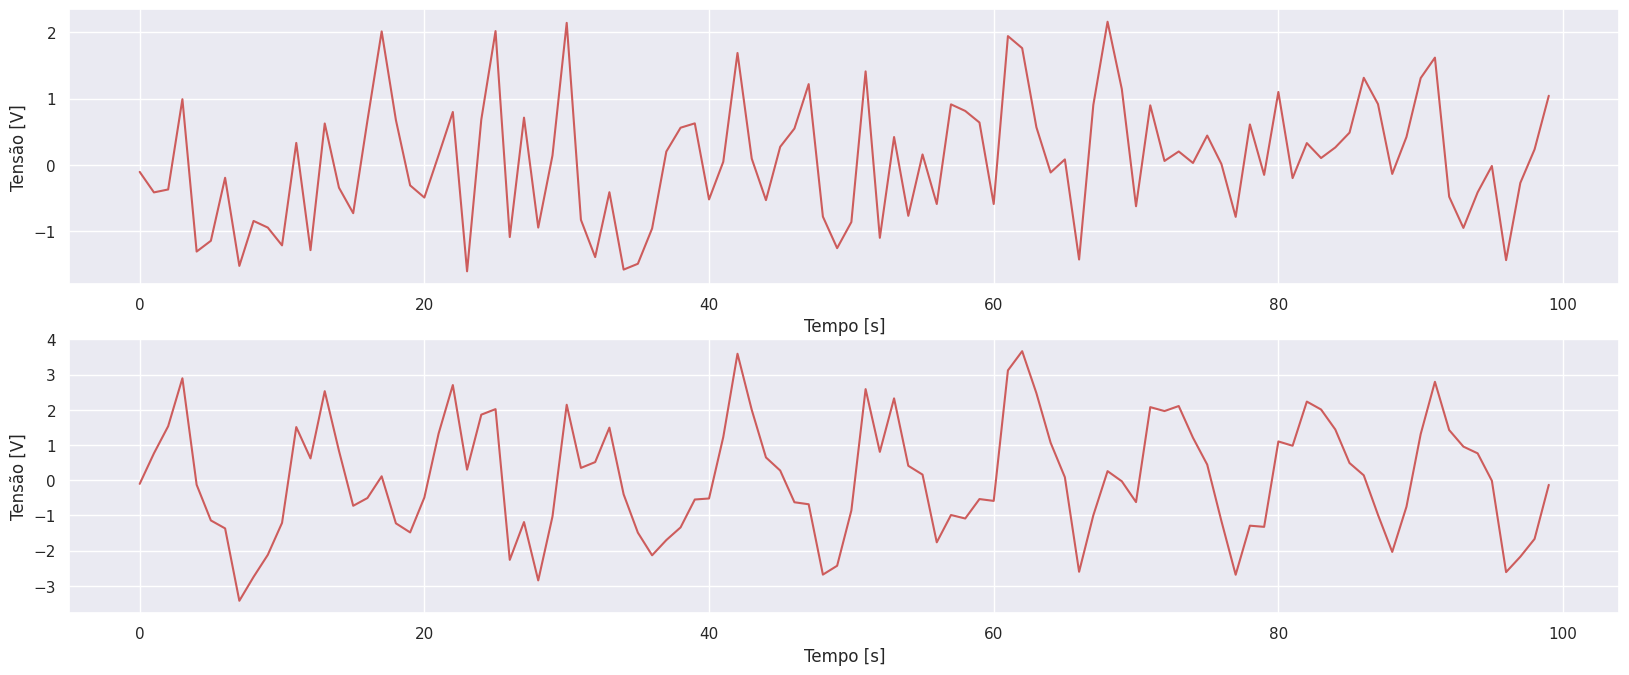

In [4]:
# Definindo uma senoide

fs = 1000
f0 = 100
f1 = 2*np.pi*f0/fs
a = 2
phase = 0
tj = 100
L = 20
N = tj*L
t = np.linspace(0,N-1,num=N)
r = rd.randn(N)
sinal = a*np.sin(t*f1 + phase)
sinal_r = sinal + r

plt.subplot(211)
sns.lineplot(y = r[0:100],x = t[0:100], color='indianred')
plt.ylabel('Tensão [V]');
plt.xlabel('Tempo [s]');

plt.subplot(212)
sns.lineplot(y = sinal_r[0:100],x = t[0:100], color='indianred')
plt.ylabel('Tensão [V]');
plt.xlabel('Tempo [s]');

In [24]:
# ORD Rayleigh
nRuns = 10000
tj = 100
M = 100
ordH1 = np.empty(shape=nRuns)
ordH2 = np.empty(shape=nRuns)
ruido_t = np.empty(shape=(nRuns,tj*M))

for i in range(nRuns):
  ruido_t[i] = rd.randn(tj*M)
  ordH2[i] = max(ord_CebullaRm(ruido_t[i],tj, M)[1])
  ordH1[i] = ord_CebullaRm(ruido_t[i],tj, M)[1][-1]

limiarH1 = vc_pratico(ordH1,alpha=0.05)
print(limiarH1)
limiarH2= vc_pratico(ordH2,alpha=0.05)
print(limiarH2)

limiarB = vc_pratico(ordH1,alpha=0.05/91)


0.17060857530212584
0.2235561789045752


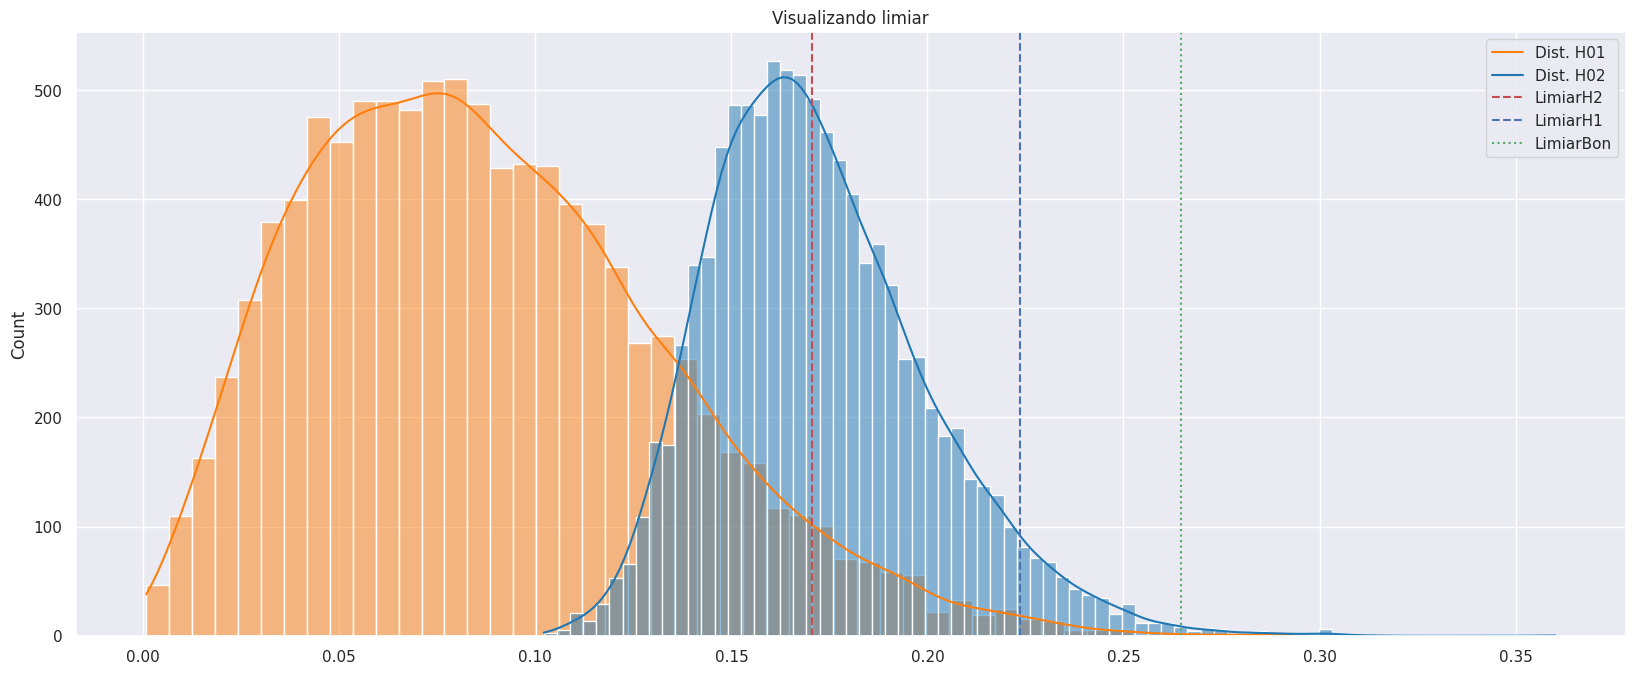

In [25]:
# Plotando distribuição
fig,ax = plt.subplots();

sns.histplot(x= ordH1, kde= True,ax=fig.axes[0],color='tab:orange')  ;
sns.histplot(x= ordH2, kde= True,ax=fig.axes[0],color='tab:blue')  ;
plt.axvline(limiarH1, 0,1,c='r',linestyle='--');
plt.axvline(limiarH2, 0,1,c='b',linestyle='--');
plt.axvline(limiarB, 0,1,c='g',linestyle=':');
fig.axes[0].set_title('Visualizando limiar');
plt.legend(['Dist. H01','Dist. H02','LimiarH2','LimiarH1','LimiarBon']);

In [26]:
# Calculando detecções por SNR

nRuns = 5000
f0 = 100
fs = 1000
tdH1 = []
tdH2 = []
N = tj*M
t = np.linspace(0,N,num=N)
ordH1 = np.empty(shape=nRuns)
ordH2 = np.empty(shape=nRuns)
for snr in range(-40,80,2):
  td1 = 0
  td2 = 0
  sinal = sin(2*np.pi*f0/fs*t)
  a = 1/10**(-snr/20)
  print(snr,end=' ')
  for n in range(nRuns):
    s = rd.randn(N) + a*sinal
    ordH1[n] = ord_CebullaRm(s,tj,M)[1][-1]
    ordH2[n] = max(ord_CebullaRm(s,tj,M)[1])
    if ordH1[n] > limiarH1:
      td1 = td1 + 1
    if ordH2[n] > limiarH2:
      td2 = td2 + 1

  por = td1*100/nRuns
  tdH1.append(por)
  por = td2*100/nRuns
  tdH2.append(por)

-40 -38 -36 -34 -32 -30 -28 -26 -24 -22 -20 -18 -16 -14 -12 -10 -8 -6 -4 -2 0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 

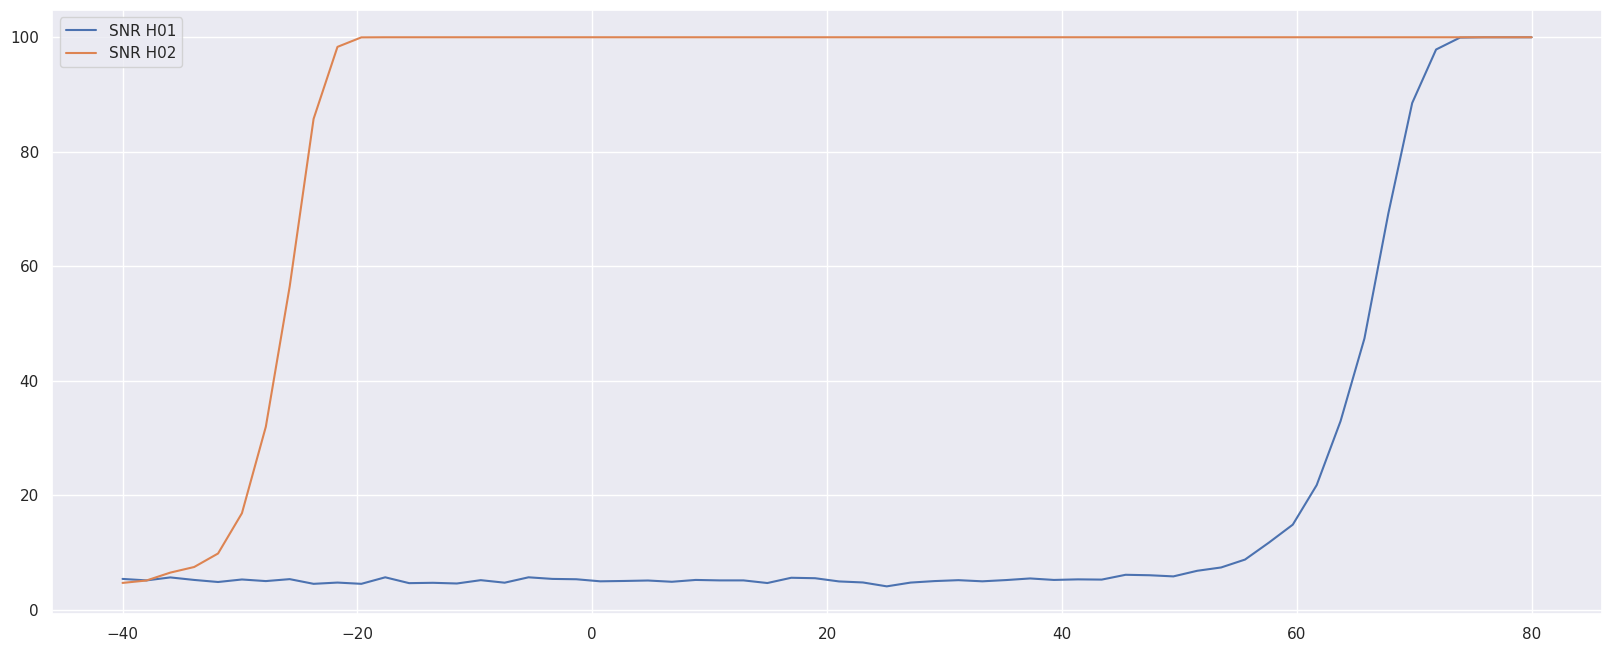

In [27]:
# Plotando gráfico SNR
snr = np.linspace(-40,80,num=60)
fig,ax = plt.subplots();

sns.lineplot(x=snr,y=tdH1,ax=fig.axes[0]);
sns.lineplot(x=snr,y=tdH2,ax=fig.axes[0]);
plt.legend(['SNR H01','SNR H02']);
